# Introdução

Em um mercado tão dinâmico e competitivo, onde a inovação tecnológica avança a passos largos, uma fabricante de laptops tem um desafio bastante comum à sua frente: a necessidade de se destacar e ganhar vantagem sobre seus concorrentes. Compreender as estratégias de preços adotadas pelos competidores pode ser a chave para alcançar a liderança no setor.
Para isso, a empresa precisa de uma ferramenta poderosa e precisa, capaz de prever com alta precisão os valores dos laptops oferecidos pelas concorrentes. Somente assim, ela poderá ajustar suas próprias ofertas de forma estratégica, garantindo produtos competitivos e alinhados com as expectativas dos consumidores, algo indispensável para qualquer empresa que deseja alcançar o topo em seus negócios.
Essa previsão não é apenas uma questão de números, mas um diferencial estratégico que pode direcionar o futuro da empresa e transformar desafios em triunfos.

In [5]:
#Bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import reshape
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from plots import * # Funções criadas especialmente para plotagem dos gráficos desse notebook
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
from sklearn.feature_selection import SelectKBest, f_regression
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 12,5

In [6]:
#Importação dos dados
laptop = pd.read_csv("laptop_prices.csv")
laptop

,Brand,Processor,RAM (GB),Storage,GPU,Screen Size,Resolution,Battery Life,Weight,Operating System,Price
0,Apple,AMD Ryzen 3,64,512GB SSD,Nvidia GTX 1650,17.3,2560x1440,8.9,1.42,FreeDOS,3997.07
1,Razer,AMD Ryzen 7,4,1TB SSD,Nvidia RTX 3080,14.0,1366x768,9.4,2.57,Linux,1355.78
2,Asus,Intel i5,32,2TB SSD,Nvidia RTX 3060,13.3,3840x2160,8.5,1.74,FreeDOS,2673.07
3,Lenovo,Intel i5,4,256GB SSD,Nvidia RTX 3080,13.3,1366x768,10.5,3.10,Windows,751.17
4,Razer,Intel i3,4,256GB SSD,AMD Radeon RX 6600,16.0,3840x2160,5.7,3.38,Linux,2059.83
...,...,...,...,...,...,...,...,...,...,...,...
11763,Acer,Intel i3,4,2TB SSD,Nvidia RTX 2060,17.3,1366x768,11.5,1.58,macOS,704.82
11764,Asus,Intel i3,4,2TB SSD,AMD Radeon RX 6800,16.0,1366x768,9.5,2.14,Linux,775.59
11765,Razer,AMD Ryzen 9,4,2TB SSD,AMD Radeon RX 6600,15.6,2560x1440,8.2,2.05,Linux,2789.46
11766,Samsung,AMD Ryzen 7,16,512GB SSD,Integrated,13.3,1920x1080,7.5,1.48,macOS,1067.13


São estes os componentes que temos disponíveis para a projeção dos preços dos concorrentes.

## Análise Exploratória

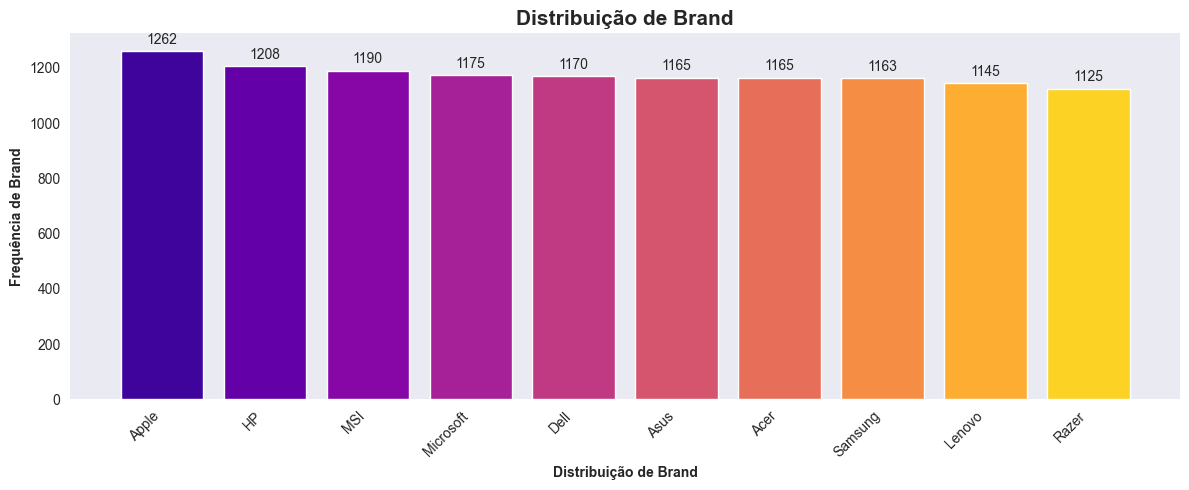

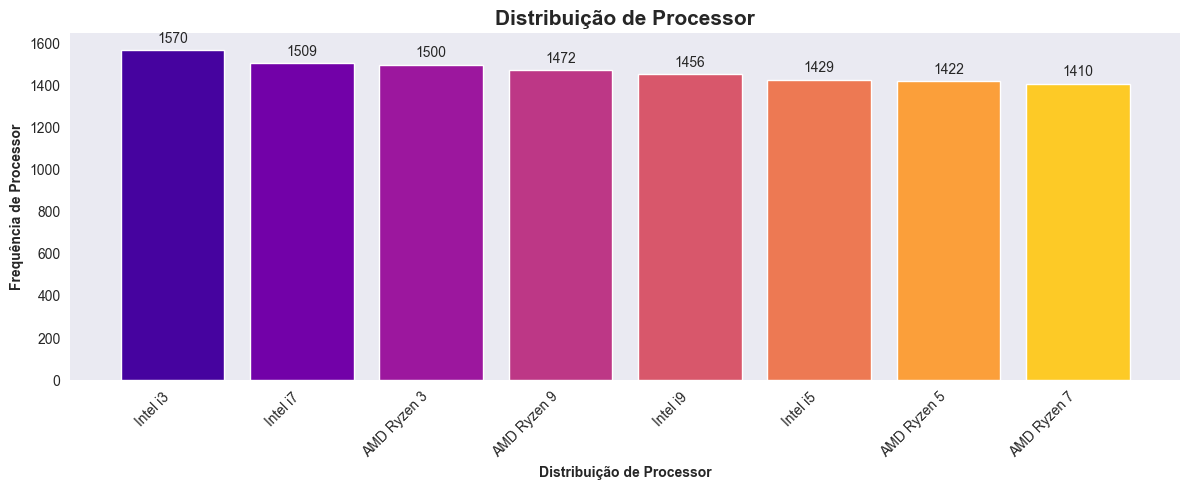

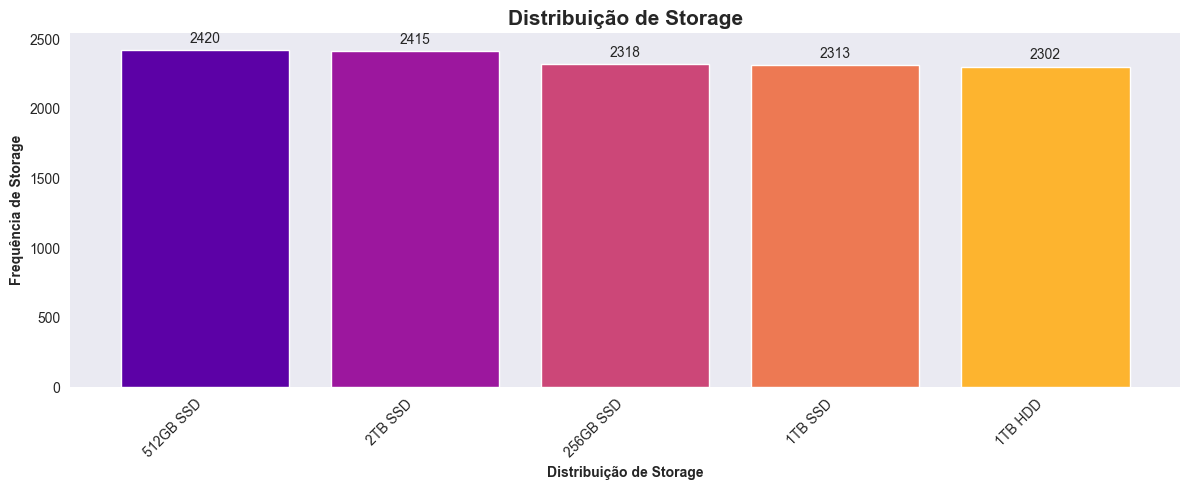

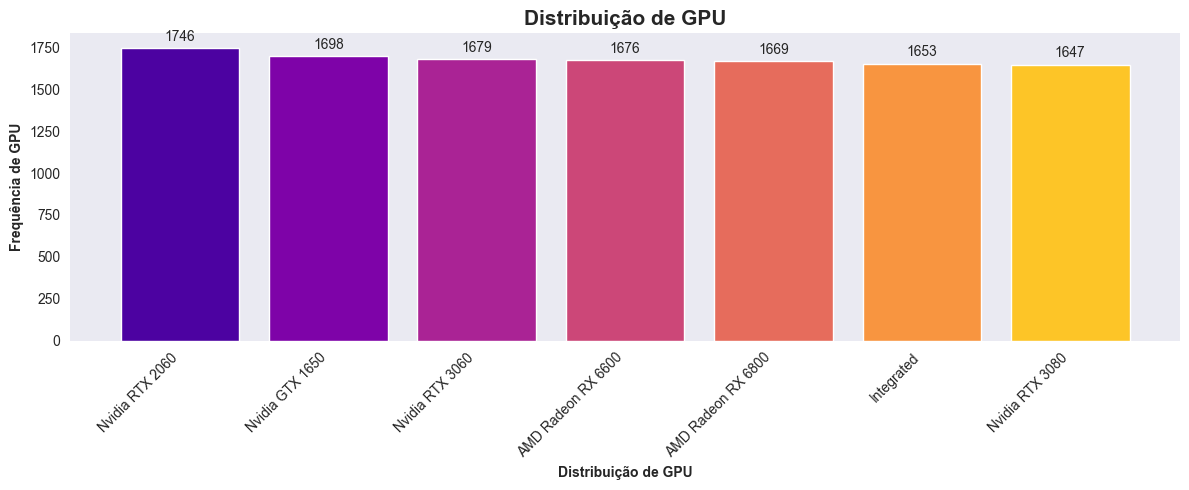

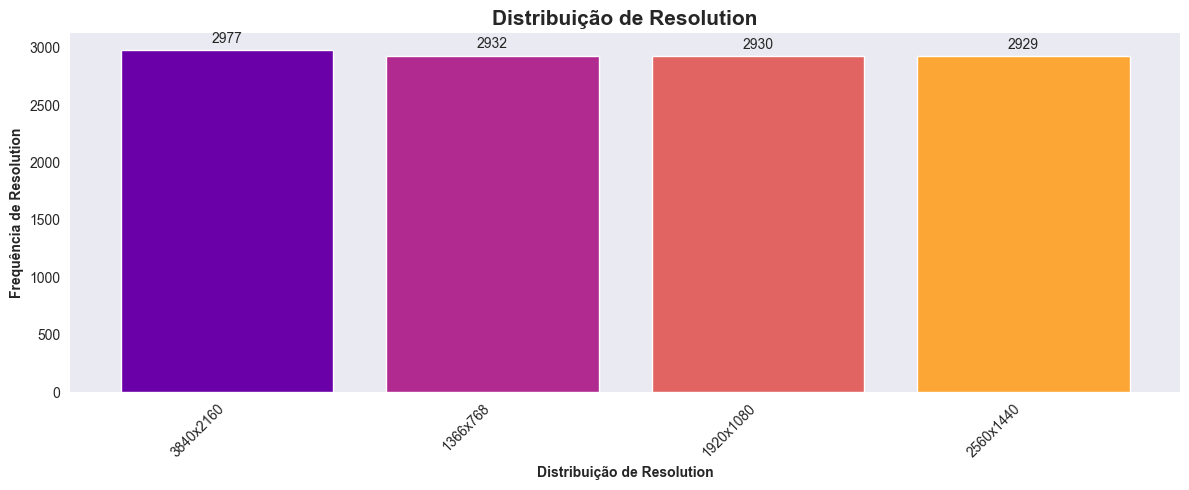

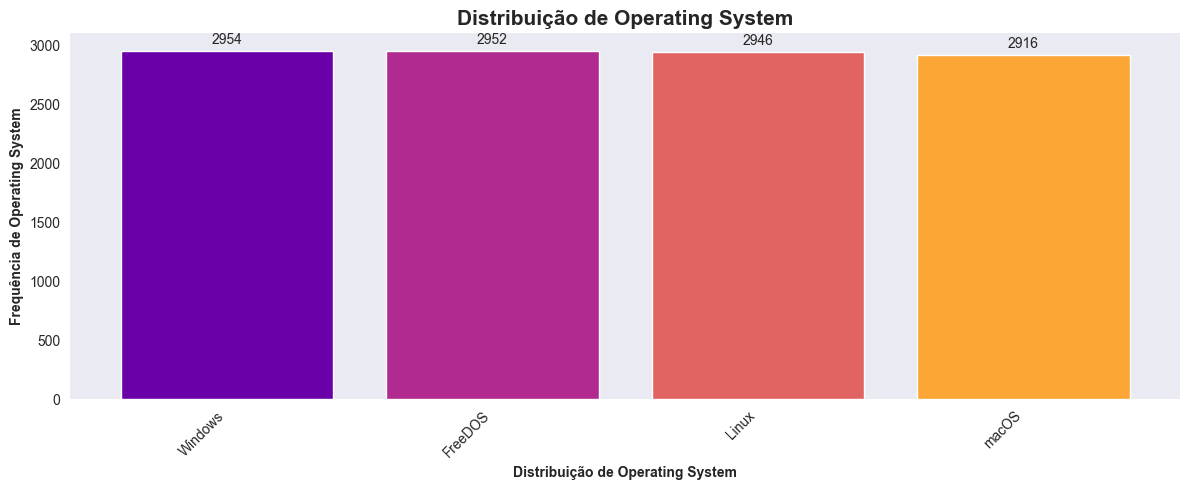

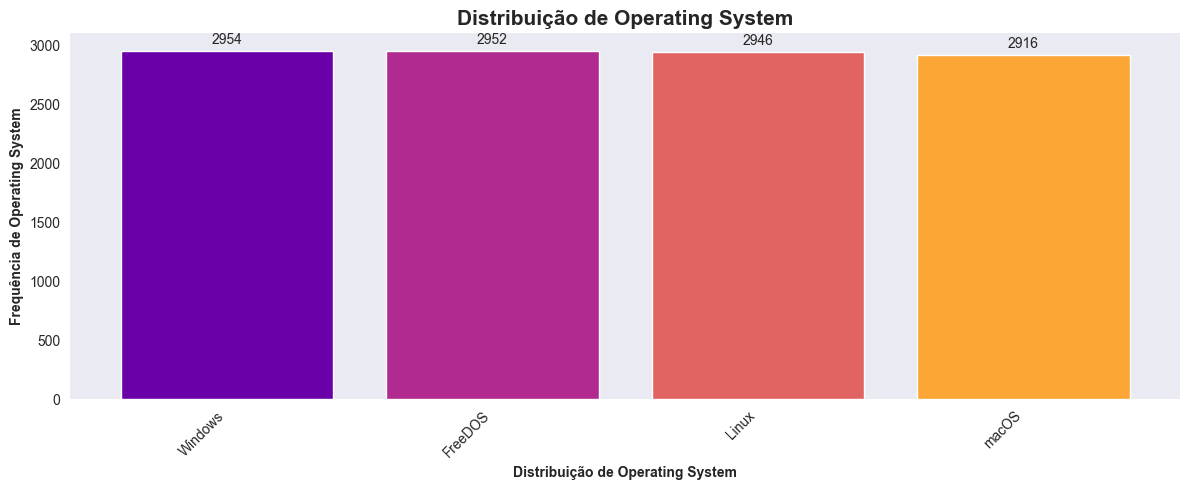

In [7]:
plot_barras(laptop, "plasma")

Tudo indica que temos dados balanceados dos laptops com amostras suficientes de cada marca para treinamento do modelo

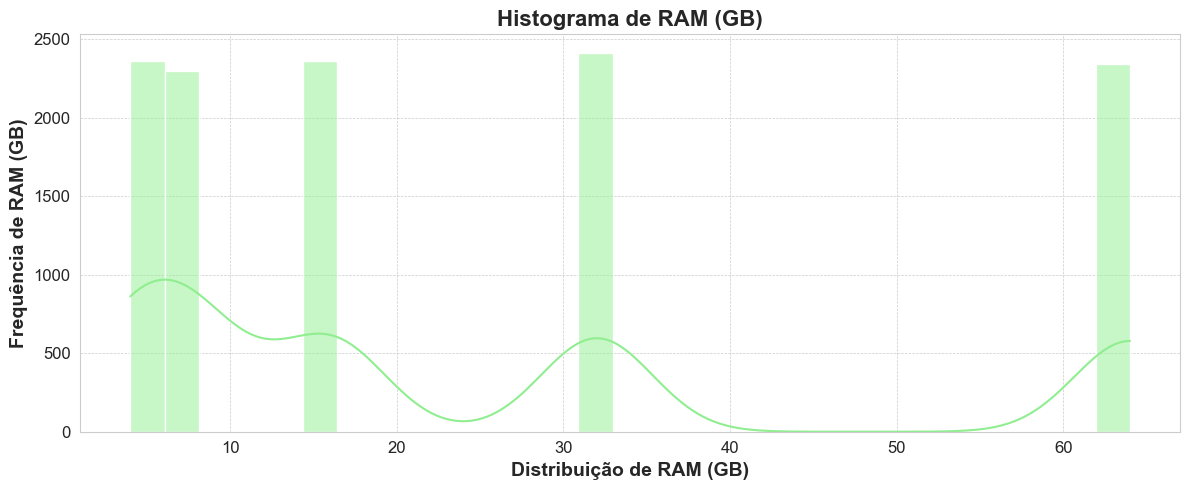

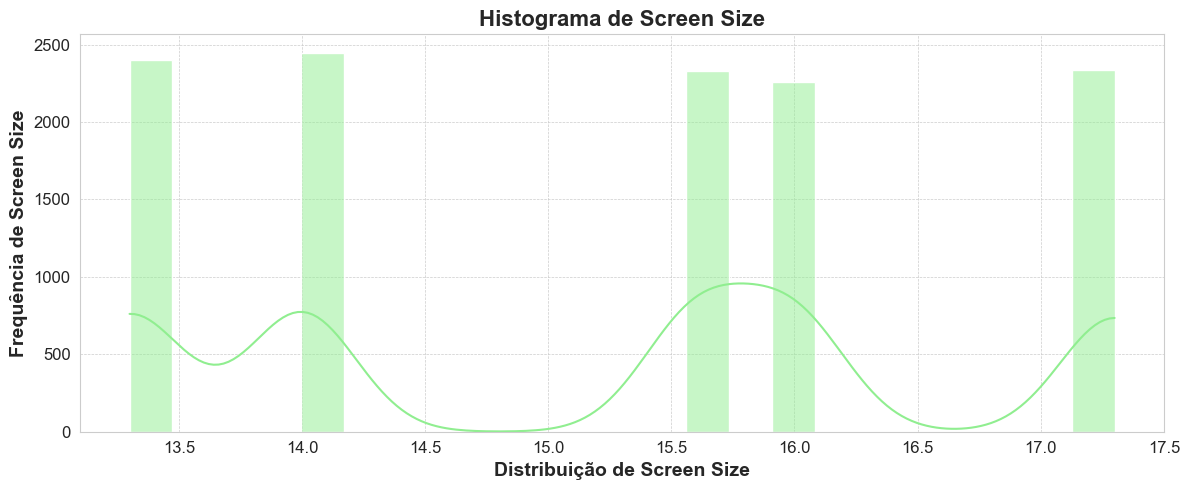

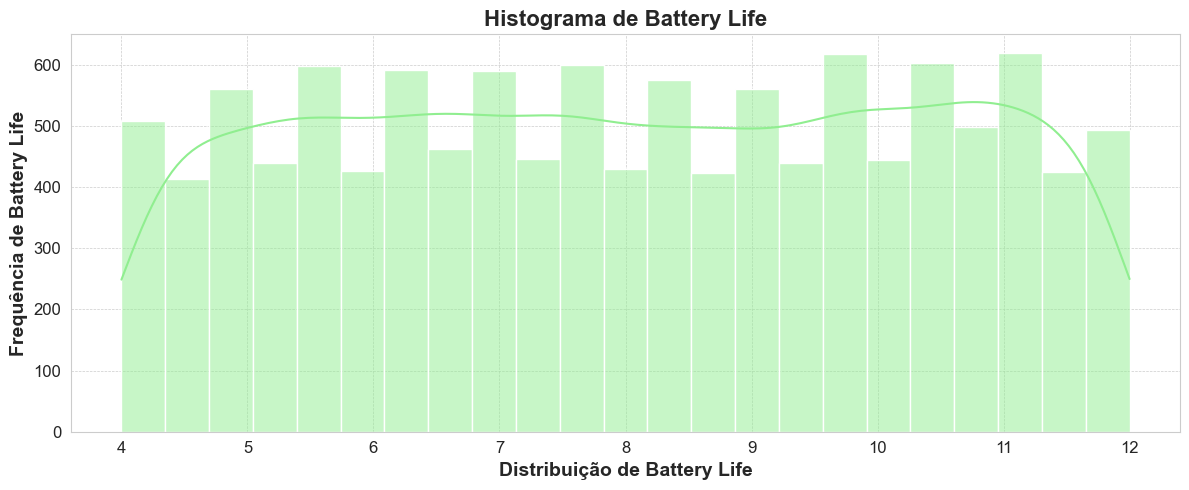

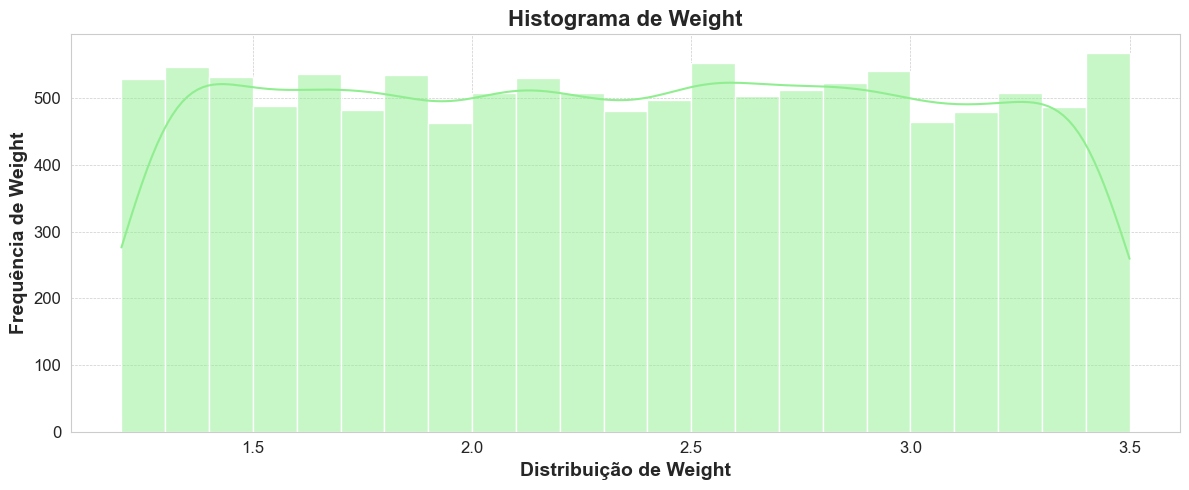

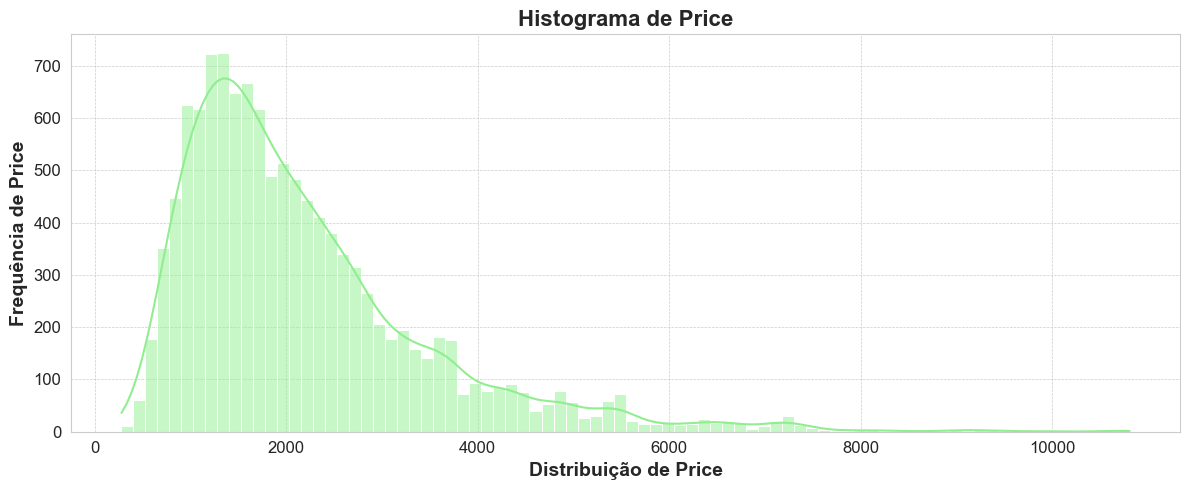

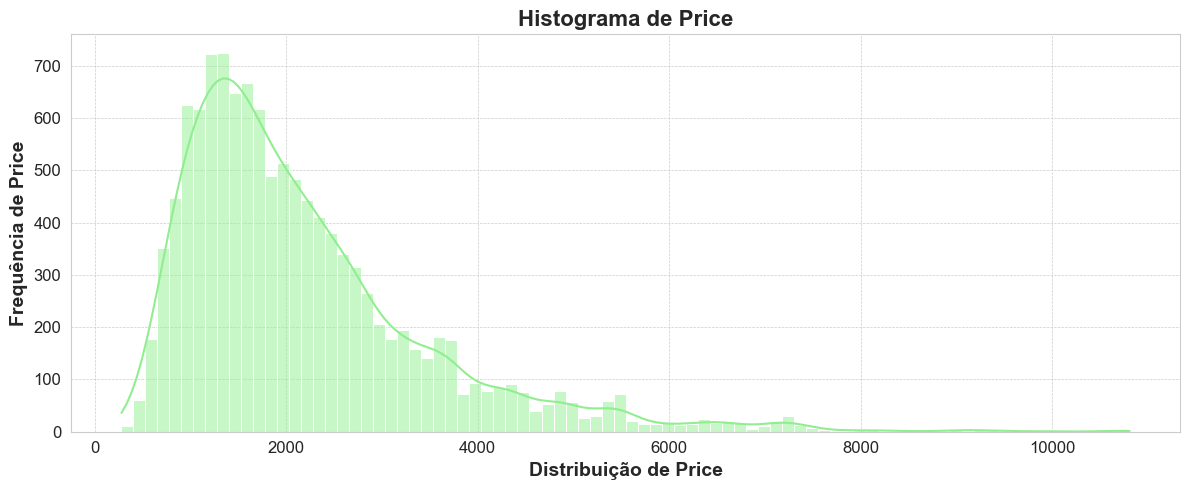

In [9]:
plot_hist(laptop, "lightgreen")

Podemos ver através desses gráficos que temos alguns valores discrepantes que chegam a ultrapassar 10.000 $, o que pode causar uma grande distorção nas decisões modelo.
Iremos remover alguns laptops com valores discrepantes, pois o objetivo é que o modelo tenha uma alta precisão em suas previsões e que ele esteja adaptado aos laptops com maior espaço no mercado..

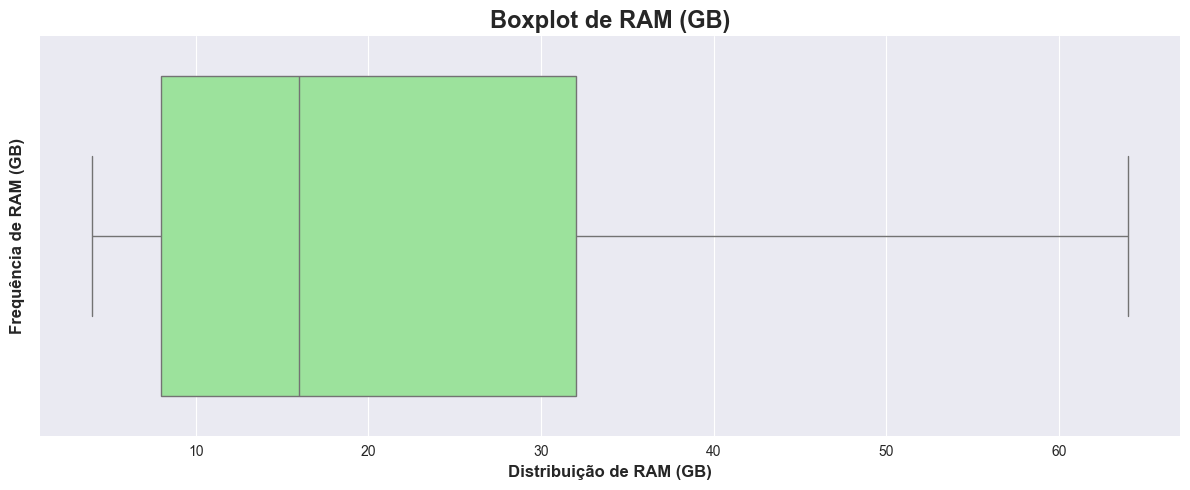

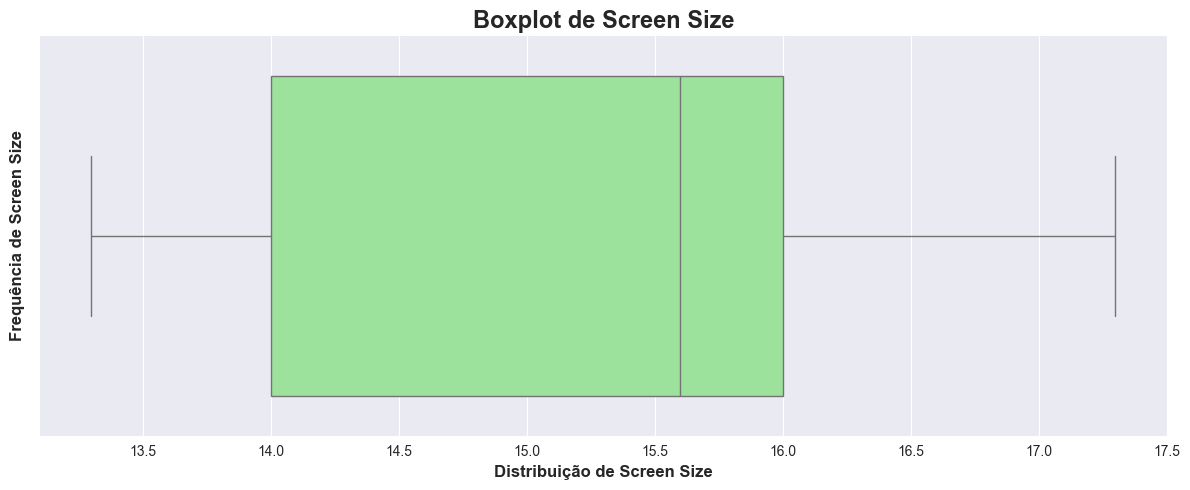

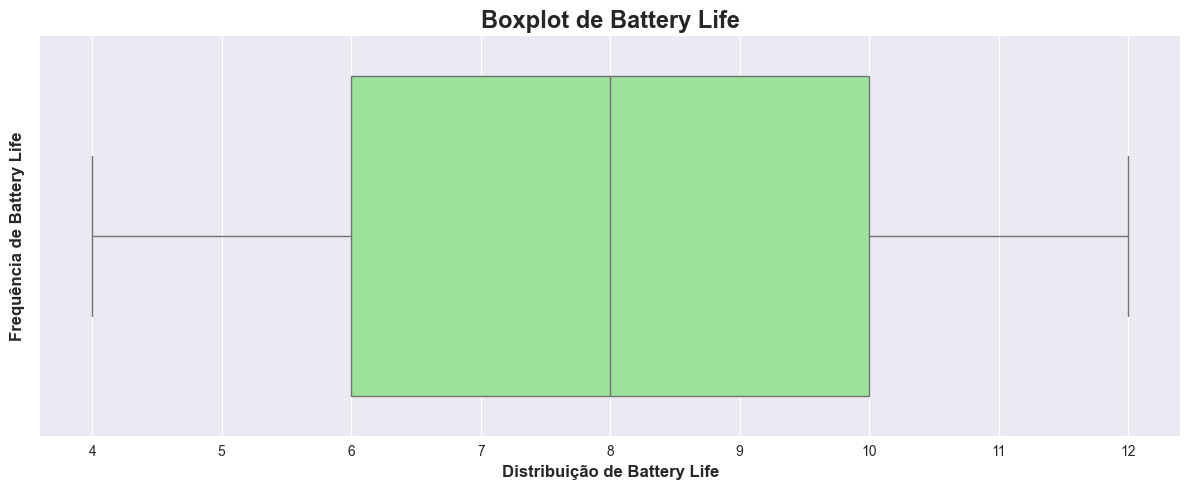

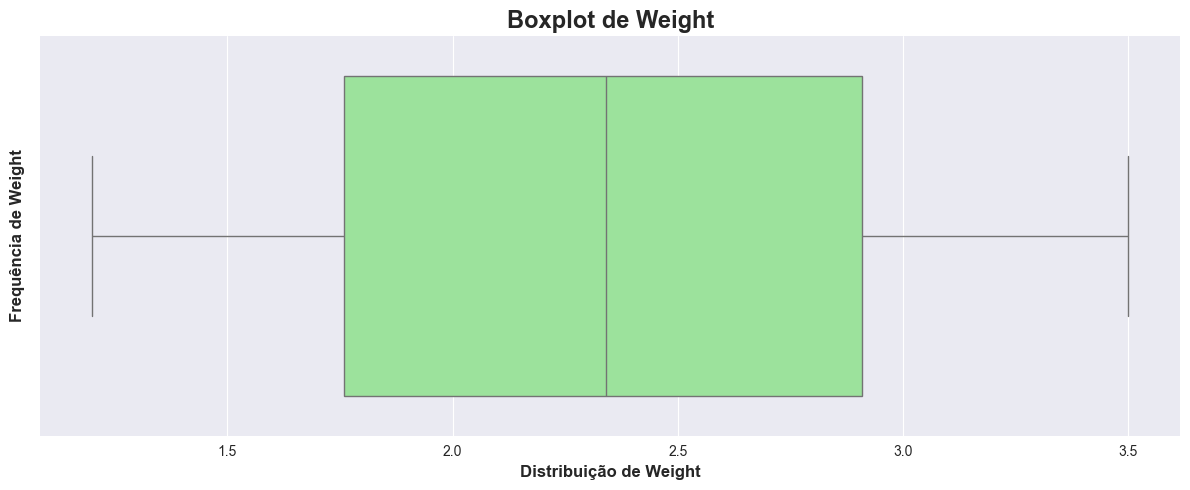

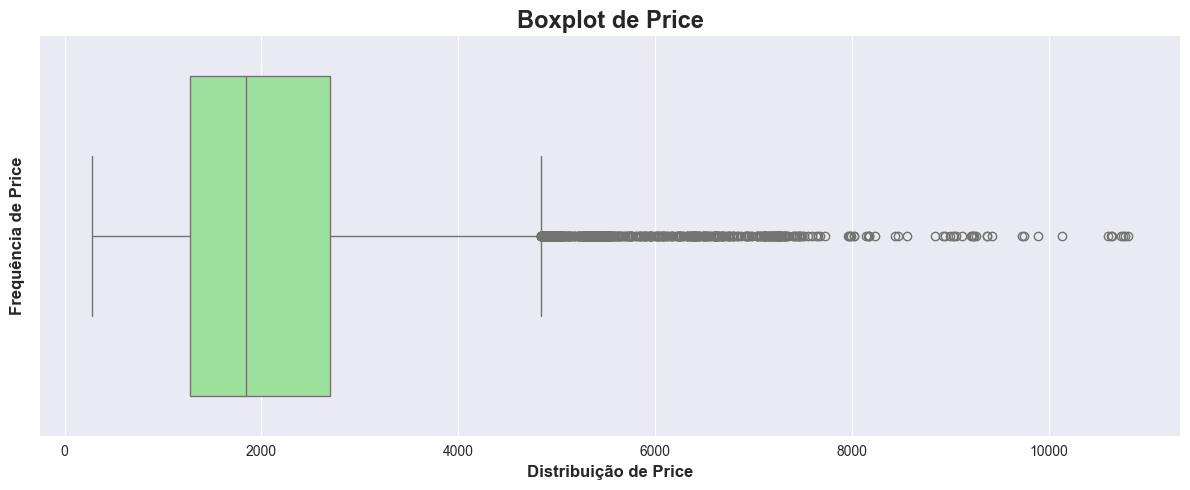

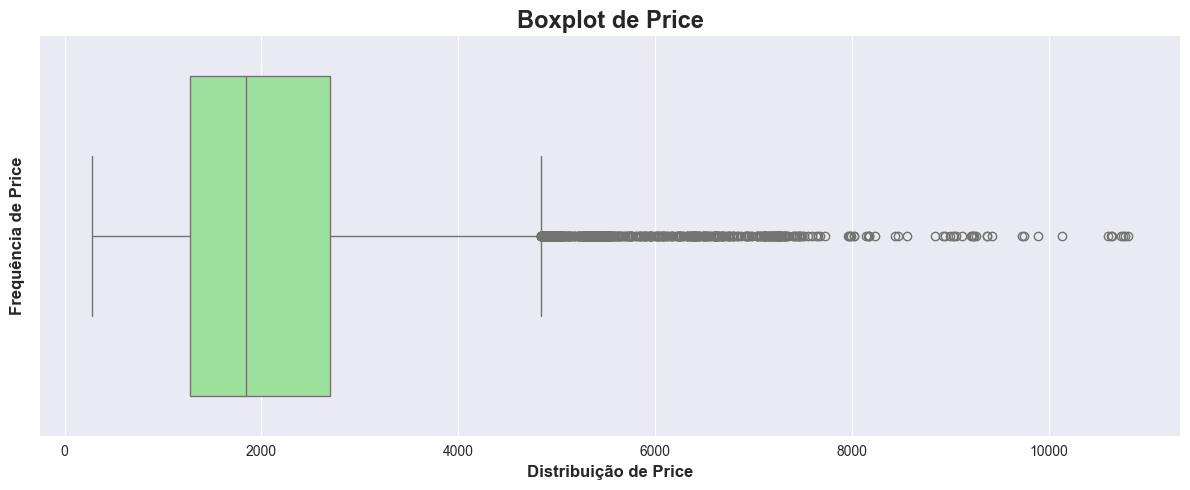

In [12]:
plot_boxplot(laptop, "lightgreen")

A empresa precisa de um modelo de alta precisão que seja capaz de prever o valor dos laptops com o qual a empresa trabalha. Por isso, iremos filtrar alguns 
laptops para que tenhamos apenas os modelos com o qual a empresa trabalha

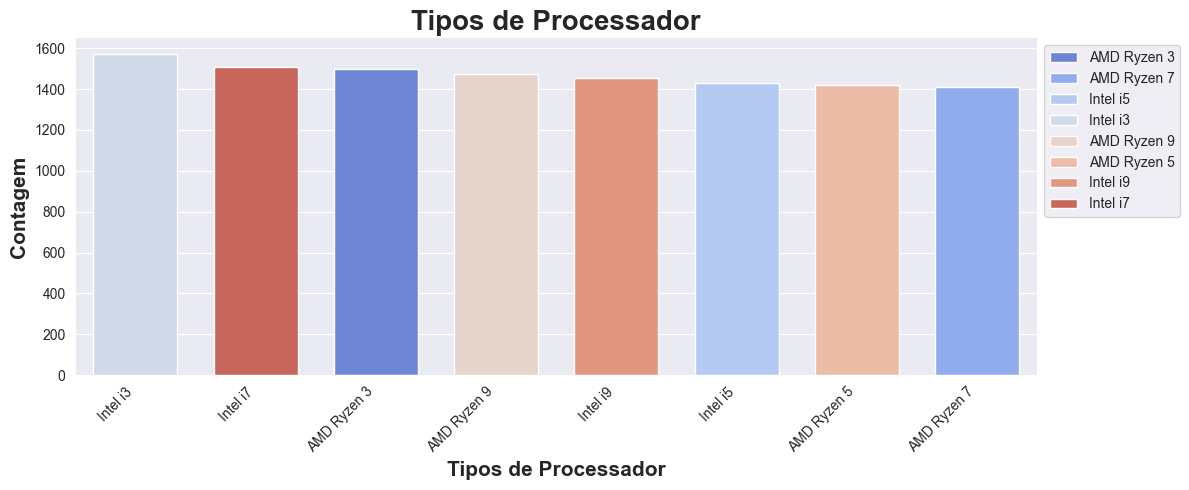

In [14]:
fig, ax = plt.subplots(figsize=(12,5))
sns.countplot(laptop, x = "Processor", hue = "Processor", order = laptop["Processor"].value_counts().index, width = 0.7, palette = "coolwarm")
ax.set_xlabel("Tipos de Processador", fontsize= 15, fontweight = "bold")
ax.set_ylabel("Contagem", fontsize = 15, fontweight = "bold")
ax.set_title("Tipos de Processador", fontsize= 20, fontweight = "bold")
plt.xticks(rotation = 45, ha = "right")
plt.legend(laptop["Processor"].unique(), bbox_to_anchor=(1.00,1))
sns.despine(right=True)
plt.tight_layout()
plt.show()


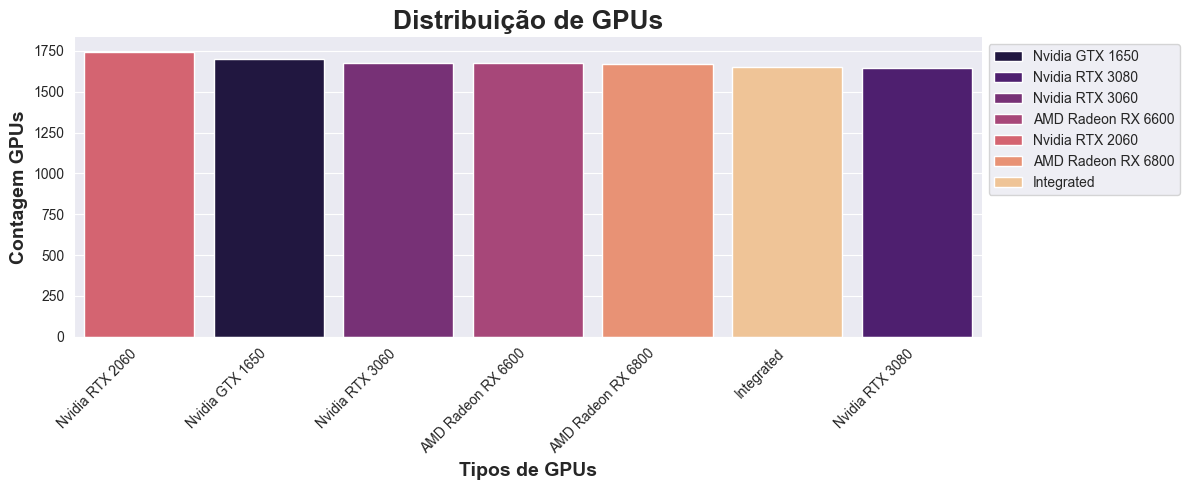

In [15]:
fig, ax = plt.subplots(figsize=(12,5))
sns.countplot(laptop, x = "GPU", hue = "GPU", order = laptop["GPU"].value_counts().index, width = 0.85, palette = "magma", ax = ax, legend="full")
ax.set_title("Distribuição de GPUs", fontweight = "bold", fontsize= 19)
ax.set_ylabel("Contagem GPUs", fontweight = "bold", fontsize = 14)
ax.set_xlabel("Tipos de GPUs", fontweight = "bold", fontsize = 14)
plt.legend(bbox_to_anchor=(1.0,1))
plt.xticks(rotation = 45, ha = "right")
sns.despine(right=True)
plt.tight_layout()
plt.show()


No gráfico de dispersão abaixo podemos ver que o tempo de bateria provavelmente não tem grande influência sobre o valor dos laptops, com vários laptops com alta capacidade de bateria
á valores relativamente baixos e alguns laptops com baixa capacidade de bateria á valores que chegam a ultrapassar a casa dos 10.000 dólares.

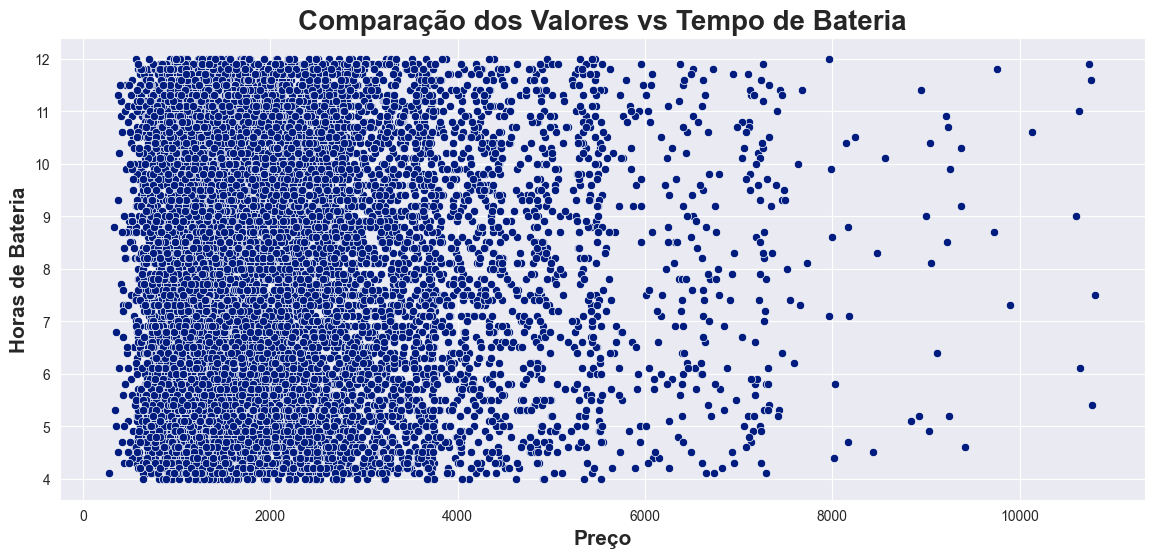

In [18]:
colors = sns.set_palette("dark", len(laptop["Price"]))
fig, ax = plt.subplots(figsize=(14,6))
sns.scatterplot(x=laptop["Price"], y=laptop["Battery Life"], hue=colors)
ax.set_ylabel("Horas de Bateria", fontsize = 15, fontweight = "bold")
ax.set_xlabel("Preço", fontsize = 15, fontweight = "bold")
ax.set_title("Comparação dos Valores vs Tempo de Bateria", fontsize=20, fontweight="bold")
plt.show()


In [19]:
laptop.isnull().any()

Brand               False
Processor           False
RAM (GB)            False
Storage             False
GPU                 False
Screen Size         False
Resolution          False
Battery Life        False
Weight              False
Operating System    False
Price               False
dtype: bool

In [20]:
laptop.describe()

,RAM (GB),Screen Size,Battery Life,Weight,Price
count,11768.000000,11768.000000,11768.000000,11768.000000,11768.000000
mean,24.852821,15.212305,8.027855,2.341117,2183.571608
std,21.762567,1.436997,2.305400,0.667921,1316.886132
min,4.000000,13.300000,4.000000,1.200000,279.570000
25%,8.000000,14.000000,6.000000,1.760000,1272.045000
50%,16.000000,15.600000,8.000000,2.340000,1840.865000
75%,32.000000,16.000000,10.000000,2.910000,2698.370000
max,64.000000,17.300000,12.000000,3.500000,10807.880000


## Filtragem e tratamento dos dados

In [21]:
desvio = laptop["Price"].std().astype(int)
desvio

1316

In [22]:
laptop2 = laptop[(laptop["Price"]>= 0.5* desvio) & (laptop["Price"]<= 4* desvio)]
laptop2.describe()

,RAM (GB),Screen Size,Battery Life,Weight,Price
count,11069.000000,11069.000000,11069.000000,11069.000000,11069.000000
mean,23.911826,15.207056,8.021818,2.341397,2049.307152
std,21.031122,1.437237,2.303971,0.667645,993.721972
min,4.000000,13.300000,4.000000,1.200000,658.270000
25%,8.000000,14.000000,6.000000,1.760000,1284.160000
50%,16.000000,15.600000,8.000000,2.350000,1814.000000
75%,32.000000,16.000000,10.000000,2.910000,2595.760000
max,64.000000,17.300000,12.000000,3.500000,5261.640000


Agora temos os laptops na faixa de preço que a empresa necessita para suas pesquisas

In [23]:
laptop2.shape

(11069, 11)

In [24]:
laptop2.describe()

,RAM (GB),Screen Size,Battery Life,Weight,Price
count,11069.000000,11069.000000,11069.000000,11069.000000,11069.000000
mean,23.911826,15.207056,8.021818,2.341397,2049.307152
std,21.031122,1.437237,2.303971,0.667645,993.721972
min,4.000000,13.300000,4.000000,1.200000,658.270000
25%,8.000000,14.000000,6.000000,1.760000,1284.160000
50%,16.000000,15.600000,8.000000,2.350000,1814.000000
75%,32.000000,16.000000,10.000000,2.910000,2595.760000
max,64.000000,17.300000,12.000000,3.500000,5261.640000


In [25]:
X = laptop2.iloc[:,:-1]
y = laptop2.iloc[:,-1]
y[:10]

0     3997.07
1     1355.78
2     2673.07
3      751.17
4     2059.83
5     1676.64
6     1449.05
7     2193.55
9     1556.72
10    2044.38
Name: Price, dtype: float64

In [26]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=3219)
X_teste.shape

(3321, 10)

In [27]:
laptop.head(1)

,Brand,Processor,RAM (GB),Storage,GPU,Screen Size,Resolution,Battery Life,Weight,Operating System,Price
0,Apple,AMD Ryzen 3,64,512GB SSD,Nvidia GTX 1650,17.3,2560x1440,8.9,1.42,FreeDOS,3997.07


In [28]:
laptop.dtypes

Brand                object
Processor            object
RAM (GB)              int64
Storage              object
GPU                  object
Screen Size         float64
Resolution           object
Battery Life        float64
Weight              float64
Operating System     object
Price               float64
dtype: object

### Codificação de Categorias e seleção de atributos

In [29]:
scaler = StandardScaler()
for col in X_treino.columns:
    if X_treino[col].dtype!= "object":
        X_treino[[col]] = scaler.fit_transform(X_treino[[col]])
        X_teste[[col]] = scaler.transform(X_teste[[col]])

In [30]:
encoder = LabelEncoder()
for col in X.columns:
    if X_treino[col].dtype=="object":
        X_treino[col] = encoder.fit_transform(X_treino[col])
        X_teste[col] = encoder.transform(X_teste[col])


In [31]:
seletor = SelectKBest(f_regression, k=7)
seletor.fit(X_treino, y_treino)
X_treino = seletor.transform(X_treino)
X_teste = seletor.transform(X_teste)

In [32]:
colunas_selecionadas = X.columns[seletor.get_support()]
print(colunas_selecionadas)

Index(['Brand', 'Processor', 'RAM (GB)', 'Storage', 'GPU', 'Screen Size',
       'Resolution'],
      dtype='object')


In [33]:
X_teste.shape

(3321, 7)

In [34]:
X_treino[0]

array([ 1.        ,  2.        , -0.37672357,  1.        ,  5.        ,
        0.28026166,  1.        ])

Vamos testar dois algoritmos o "ExtraTreesRegressor" e o "XGBRegressor" utilizando otimizador bayesiano para encontrar os melhores hiper-parâmetros possíveis.
Há uma grande combinação possível de hiper-parâmtros, e o otimizador bayesiano vai economizar tempo e recursos computacionais além de encontrar os hiper-parâmetros com o erro mais baixo.

### ExtraTreesRegressor

In [35]:
extra_trees = ExtraTreesRegressor()
param_space = {
    'n_estimators': Integer(10, 1000),
    'max_features': Real(0.1, 1.0),
    'max_depth': Integer(1, 50),
    'min_samples_split': Integer(2, 30),
    'min_samples_leaf': Integer(1, 30),
    "max_leaf_nodes": Integer(2,100),
    "bootstrap": Categorical([True, False])
}
optim_trees = BayesSearchCV(extra_trees, param_space, verbose=2, n_jobs=-1, error_score="raise", cv=5, n_iter=64)
optim_trees.fit(X_treino, y_treino)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5, estimator=ExtraTreesRegressor(), n_iter=64, n_jobs=-1,
              search_spaces={'bootstrap': Categorical(categories=(True, False), prior=None),
                             'max_depth': Integer(low=1, high=50, prior='uniform', transform='normalize'),
                             'max_features': Real(low=0.1, high=1.0, prior='uniform', transform='normalize'),
                             'max_leaf_nodes': Integer(low=2, high=100, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=1, high=30, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=30, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=10, high=1000, prior='uniform', transform='normalize')},
              verbose=2)

In [36]:
print(optim_trees.best_params_)

OrderedDict({'bootstrap': False, 'max_depth': 40, 'max_features': 1.0, 'max_leaf_nodes': 100, 'min_samples_leaf': 12, 'min_samples_split': 2, 'n_estimators': 1000})


In [37]:
optim_trees.best_score_

0.7654622488242251

In [38]:
modelo_trees = optim_trees.best_estimator_

In [39]:
previsoes_trees = modelo_trees.predict(X_teste)
previsoes_trees[:20]

array([2152.47125145, 1640.56520622, 1020.48789224, 1660.48886307,
       3752.67320806, 2094.42096878, 2940.78520993, 1288.99401277,
       1590.61412332, 3751.29887198, 2701.28245166, 2456.79106024,
       1291.22184376, 1210.43786562, 1191.95934681, 2922.24784161,
       2039.02547729,  960.21221476, 1507.52272139, 3243.87541602])

In [40]:
squared_error = root_mean_squared_error(y_teste, previsoes_trees)
perc_error = mean_absolute_percentage_error(y_teste, previsoes_trees)
print("RMSE: %4f" % squared_error)
print(f"MAPE: {perc_error*100:.2f}% ")

RMSE: 466.665596
MAPE: 18.83% 


### XGBRegressor

In [85]:
xgb_regressor = XGBRegressor(objective="reg:squarederror")
param_space = {
    'n_estimators': (50, 100, 300, 500, 1000),
    'learning_rate': (0.001, 0.01, 0.1, 0.5, 1.0 ),
    'max_depth': (1, 10, 15, 20, 30, 50,100 ),
    'subsample': (0.1, 0.5, 1.0),
    'colsample_bytree': (0.1, 0.25, 0.5, 1.0),
    "max_leaves": (0, 5, 10, 15, 20, 30, 50, 100 )
}

optim_xgb = BayesSearchCV(xgb_regressor, param_space, n_jobs=-1, verbose=2, error_score="raise", cv=5, n_iter=64)
optim_xgb.fit(X_treino, y_treino)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
              n_iter=64, n_jobs=-1,
              search_spaces={'colsample_bytree': (0.1, 0.25, 0.5, 1.0),
                             'learning_rate': (0.001, 0.01, 0.1, 0.5, 1.0),
                             'max_depth': (1, 10, 15, 20, 30, 50, 100),
                             'max_leaves': (0, 5, 10, 15, 20, 30, 50, 100),
                             'n_estimators': (50, 100, 300, 500, 1000),
                             'subsample': (0.1, 0.5, 1.0)},
              verbose=2)

In [86]:
print(optim_xgb.best_params_)

OrderedDict({'colsample_bytree': 0.5, 'learning_rate': 0.5, 'max_depth': 50, 'max_leaves': 15, 'n_estimators': 1000, 'subsample': 1.0})


In [87]:
modelo_xgb = optim_xgb.best_estimator_

In [88]:
previsoes = modelo_xgb.predict(X_teste)
previsoes[:20]

array([1848.118  , 2657.732  ,  736.21484, 2223.4128 , 3253.419  ,
       1875.1204 , 3457.3596 , 1283.314  , 1242.5458 , 4126.417  ,
       2635.1948 , 1548.2833 , 1208.62   ,  796.61584,  942.82965,
       2108.208  , 1492.5388 , 1097.5122 , 1505.8396 , 4663.656  ],
      dtype=float32)

In [89]:
y_teste[:20]

2010     1812.48
9174     2605.98
10099     663.21
3016     2163.17
9978     3316.96
3468     1908.87
11020    3436.94
2099     1300.27
4213     1256.60
1715     4164.77
4750     2719.82
1200     1766.95
9149     1162.62
7661      719.78
3392      934.55
7884     2166.48
7155     1372.88
6408     1263.69
8248     1429.00
1704     4952.41
Name: Price, dtype: float64

In [90]:
squared_error = root_mean_squared_error(y_teste, previsoes)
perc_error = mean_absolute_percentage_error(y_teste, previsoes)
print("RMSE: %4f" % squared_error)
print(f"MAPE: {perc_error*100:.2f}% ")

RMSE: 104.138619
MAPE: 5.14% 


Conseguimos um desempenho excelente com o XGBRegressor por isso vamos utilizá-lo na construção da aplicação

In [91]:
row = reshape((X_teste[10,:]), (1,-1))
row

array([[5.        , 5.        , 1.90259254, 2.        , 5.        ,
        1.46275077, 1.        ]])

## Explicabilidade Adicional

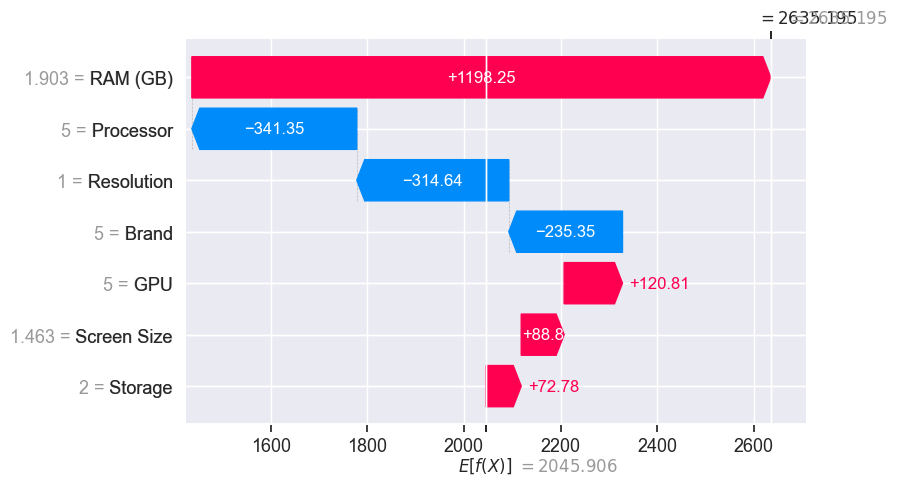

<Figure size 1400x600 with 0 Axes>

In [92]:
explainer = shap.Explainer(modelo_xgb, feature_names=colunas_selecionadas)
explain = explainer(row)
shap.plots.waterfall(explain[0])
plt.tight_layout()

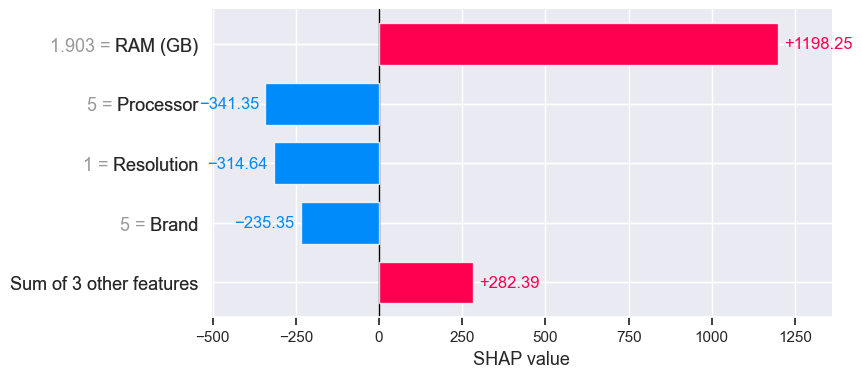

In [93]:
shap.plots.bar(explain[0], max_display=5)

O gráfico acima explica uma instância específica do conjunto de dados. Podemos ver que nesse caso a memória RAM com maior capacidade 
impulsionou significativamente o valor do laptop para cima, enquanto variáveis como processador, resolução e a marca do laptop empurraram negativamente o valor
do laptop ainda que não tão significativamente quanto a memória RAM.

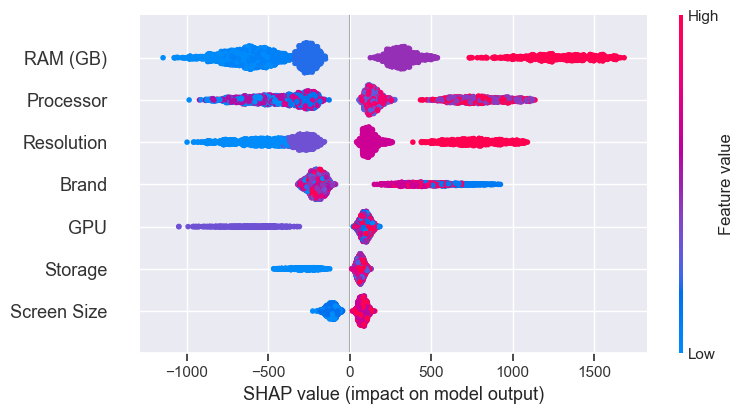

In [94]:
explainer = shap.Explainer(modelo_xgb)
shap_values = explainer.shap_values(X_teste)
shap.summary_plot(shap_values, X_teste, feature_names=(X.columns))

Aqui vemos os componentes com maior peso nas decisões do modelo de maneira global, com destaque novamente para memórias RAMs com alta capacidade que impulsionam significativamente o valor do laptop.
Destaque também para alguns tipos de processadores que impactam positivamente ou negativamente o valor do notebook e por último mas não menos importante a resolução assim como a memória RAM tem valores 
de diferentes observações dispersos o que indica que ela pode impulsionar significativamente o valor dos laptops, positiva ou negativamente de acordo com cada caso específico